In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from smerf.models import *
import pickle
import cv2
CACHE_DIR = '../outputs/cache'

# plot bounding box using the metadata
def plot_bbox(axs, primary_lst, secondary_lst, idx):
    if axs == None:
        f, axs = plt.subplots(1,1)

    p = primary_lst[idx]
    s = secondary_lst[idx]
    if p != []:
        for po in p:
            x1, x2, y1, y2 = po[2], po[3], po[1], po[0]
            axs.plot([x1, x1], [y1, y2], color='g', linewidth=5)
            axs.plot([x1, x2], [y2, y2], color='g', linewidth=5)
            axs.plot([x2, x2], [y2, y1], color='g', linewidth=5)
            axs.plot([x2, x1], [y1, y1], color='g', linewidth=5)
    if s != []:
        for so in s:
            x1, x2, y1, y2 = so[2], so[3], so[1], so[0]
            axs.plot([x1, x1], [y1, y2], color='m', linewidth=5)
            axs.plot([x1, x2], [y2, y2], color='m', linewidth=5)
            axs.plot([x2, x2], [y2, y1], color='m', linewidth=5)
            axs.plot([x2, x1], [y1, y1], color='m', linewidth=5)

# load model for each reasoning and obtain predictions and accuracy
def get_model_predictions(exp_no, imgs, labels):
    model_name = 'w%0.2f.pt'%exp_no
    if exp_no >= 3.5 or exp_no == 1.2:
        model_obj = TextBoxCNN_adv(lr=0.001, 
                                model_name=model_name, 
                                max_epoch=100, 
                                output_dir=CACHE_DIR)
    else:
        model_obj = TextBoxCNN(lr=0.001, 
                                model_name=model_name, 
                                max_epoch=100, 
                                output_dir=CACHE_DIR)
    model_obj.train(imgs, labels, retrain=False, earlystop=True)
    test_acc = model_obj.test(imgs, labels)
    return model_obj.model.predict_classes(imgs), test_acc

Using TensorFlow backend.


## Example Data Points and Primary/Secondary Objects

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_450 (Conv2D)          (None, 31, 31, 32)        896       
_________________________________________________________________
conv2d_451 (Conv2D)          (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_452 (Conv2D)          (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_130 (Flatten)        (None, 3136)              0         
_________________________________________________________________
dense_321 (Dense)            (None, 200)               627400    
_________________________________________________________________
dense_322 (Dense)            (None, 2)                 402       
Total params: 684,122
Trainable params: 684,122
Non-trainable params: 0
_________________________________________________________________
None

Accuracy=1.000000


Text(0.5, 1.01, 'Data Samples From Each Reasoning with Primary (Green) and Secondary (Magenta) Objects')

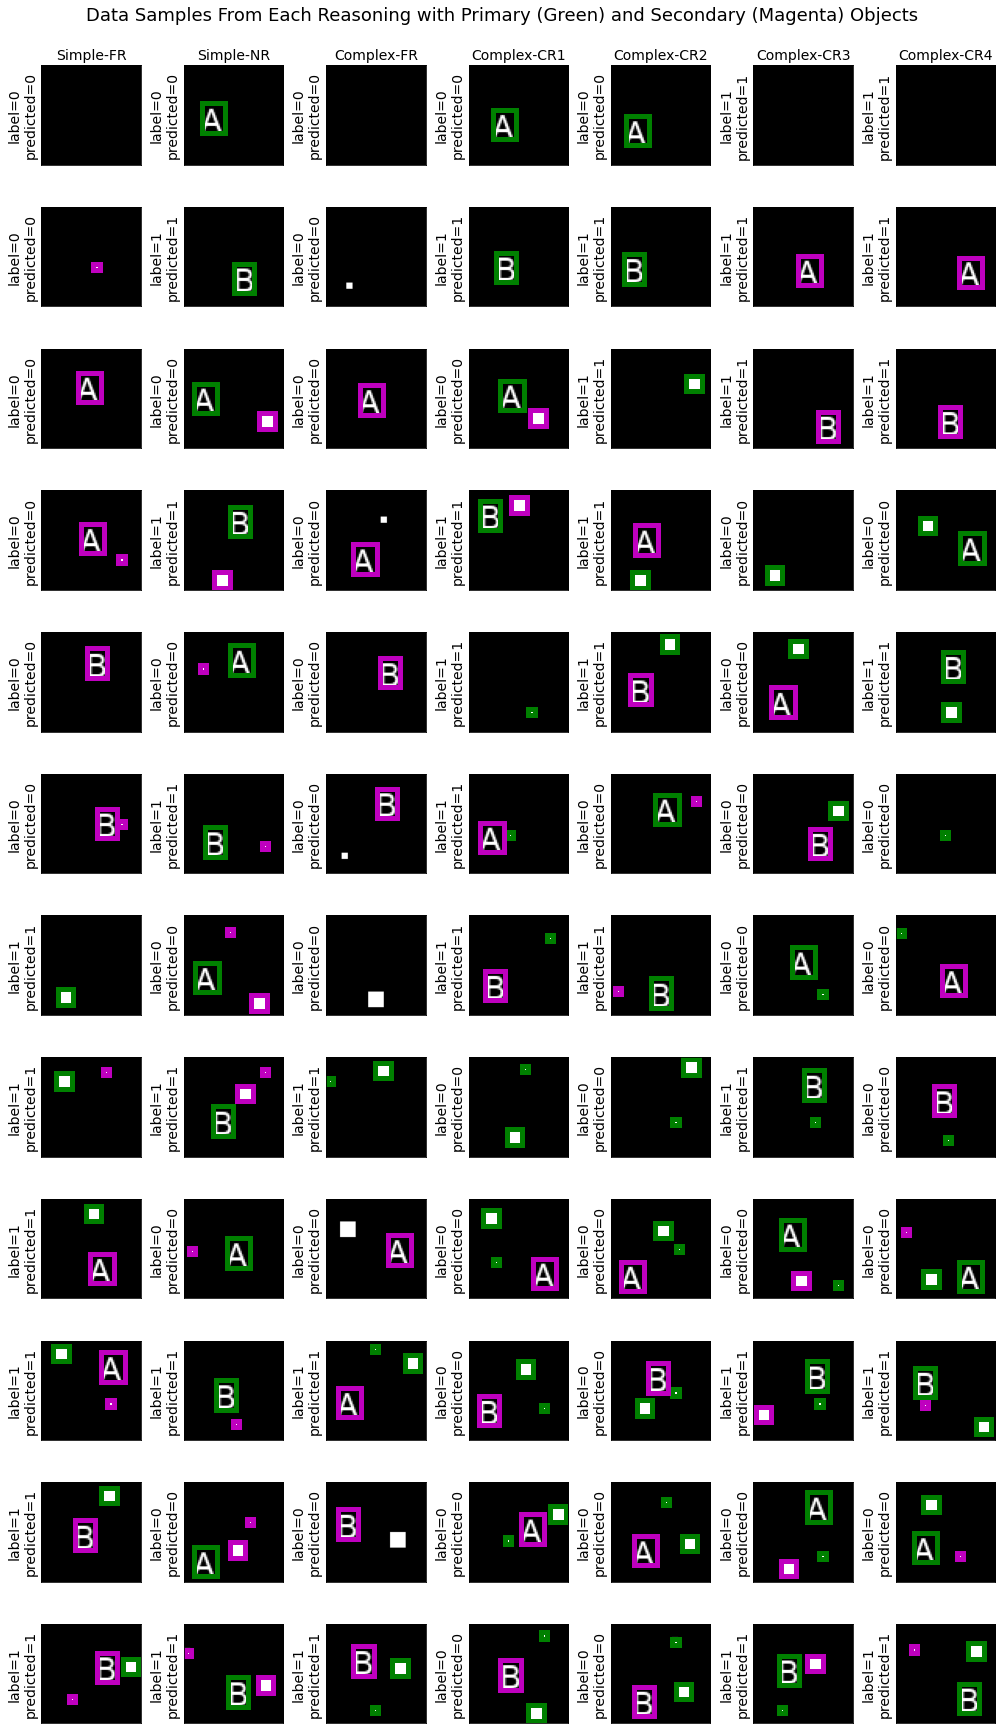

In [52]:
reasoning = [1.11, 2.11, 1.20, 3.71, 3.72, 3.73, 3.74]
names = ['Simple-FR', 'Simple-NR', 'Complex-FR', 'Complex-CR1', 'Complex-CR2', 'Complex-CR3', 'Complex-CR4']
no_samples = 12
f, axs = plt.subplots(no_samples, len(reasoning), figsize=(2*len(reasoning), 2*no_samples))
labelname = {0: 'A', 1:'B'}
for j, r in enumerate(reasoning):
    data = np.load('../data/textbox_%0.2f.npz'%r, allow_pickle=True)
    imgs = data['x_test']
    labels = data['y_test']
    primary_lst, secondary_lst = data['test_primary'], data['test_secondary']
    if r == 2.11:
        idx = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 2001, 2501, 3002, 3501]
    elif r > 3:
        idx = [0, 400, 800, 1200, 1600, 2001, 2400, 2800, 3200, 3601, 3201, 3605]
    else:
        idx = [0, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000, 4500, 5000, 5501]
        
    predictions, acc = get_model_predictions(r, imgs[idx], labels[idx])
        
    for i,k in enumerate(idx):
        axs[i,j].imshow(imgs[k])
        axs[i,j].set_xticks(())
        axs[i,j].set_yticks(())
        axs[i,j].set_ylabel('label=%s\npredicted=%s'%(int(labels[k]), int(predictions[i])), fontsize=14)
        plot_bbox(axs[i,j], primary_lst, secondary_lst, k)
    axs[0,j].set_title(names[j], fontsize=14)
plt.tight_layout()
plt.suptitle("Data Samples From Each Reasoning with Primary (Green) and Secondary (Magenta) Objects", fontsize=18,  y=1.01)
#plt.savefig('datapoints.pdf', dpi=200, bbox_inches='tight')

## Bucket-wise Accuracy

In [12]:
# convert img order to follow bucket ID no in the paper
idx_ref = dict()
idx_ref['1.11'] = [0, 2, 4, 1, 3, 5, 6, 8, 10, 7, 9, 11]
idx_ref['2.11'] = [-1, 0, 1, -1, 4,5,-1, 2,3,-1,6,7]
idx_ref['1.20'] = [0,2,4,1,3,5,6,8,10,7,9,11]
idx_ref['3.71'] = [-1, 0,1,4,5,6,-1,2,3,7,8,9]
idx_ref['3.72'] = [-1,0,1,-1,5,6,2,3,4,7,8,9]
idx_ref['3.73'] = [0,1,2,-1,6,7,3,4,5,-1,8,9]
idx_ref['3.74'] = [0,1,2,5,6,7,-1,3,4,-1,8,9]

def generate_idx_order(idx_ref_elem, test_no):
    out = []
    for i in idx_ref_elem:
        if i == -1:
            out.append([])
        else:
            out.append(range(test_no*i, test_no*(i+1)))
    return out

accuracy = np.zeros((len(reasoning), 12))
for i, r in enumerate(reasoning):
    if r < 3:
        test_no = 500
        if r == 2.11:
            bucket_no = 8
        else:
            bucket_no = 12
    else:
        test_no = 400
        bucket_no = 10
    data = np.load('../data/textbox_%0.2f.npz'%r, allow_pickle=True)
    imgs = data['x_test']
    labels = data['y_test']
    order = generate_idx_order(idx_ref['%0.2f'%r], test_no)
    predictions, acc = get_model_predictions(r, imgs, labels)
    assert(len(order) == 12)
    for j,idx in enumerate(order):
        if len(idx) == 0:
            acc = -1
        else:
            acc = (predictions[idx] == labels[idx]).sum() / len(idx)
        accuracy[i,j] = acc
        
print(accuracy)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_424 (Conv2D)          (None, 31, 31, 32)        896       
_________________________________________________________________
conv2d_425 (Conv2D)          (None, 15, 15, 64)        18496     
_________________________________________________________________
conv2d_426 (Conv2D)          (None, 7, 7, 64)          36928     
_________________________________________________________________
flatten_123 (Flatten)        (None, 3136)              0         
_________________________________________________________________
dense_302 (Dense)            (None, 200)               627400    
_________________________________________________________________
dense_303 (Dense)            (None, 2)                 402       
Total params: 684,122
Trainable params: 684,122
Non-trainable params: 0
_________________________________________________________________
None

Accuracy=0.986000
[[ 1.      1.      1.      1.      1.      1.      1.      1.      1.
   1.      1.      1.    ]
 [-1.      1.      1.     -1.      1.      1.     -1.      1.      1.
  -1.      1.      1.    ]
 [ 1.      1.      1.      1.      1.      1.      1.      1.      1.
   1.      0.968   0.976 ]
 [-1.      1.      1.      1.      0.95    1.     -1.      1.      0.9575
   1.      1.      0.975 ]
 [-1.      1.      1.     -1.      1.      0.9975  1.      1.      1.
   1.      0.975   0.9125]
 [ 1.      1.      1.     -1.      0.9875  1.      1.      1.      0.995
  -1.      1.      0.9   ]
 [ 1.      1.      1.      0.9975  0.95    0.9225 -1.      0.9975  0.9975
  -1.      1.      0.995 ]]


## Primary/Secondary Attribution Focus Level Demo

In [2]:
import imp
textcolorutils = imp.load_source('textcolor_utils', '../smerf/textcolor_utils.py')

reasoning = 3.71
bucket_id = 3
if reasoning < 3:
    test_no = 500
    if reasoning == 2.11:
        bucket_no = 8
    else:
        bucket_no = 12
else:
    test_no = 400
    bucket_no = 10
data = np.load('../data/textbox_%0.2f.npz'%reasoning, allow_pickle=True)
primary_lst, secondary_lst = data['test_primary'], data['test_secondary']
result_fname = CACHE_DIR + '/result_%0.2f_%d.pkl'%(reasoning, bucket_id)
idx = pickle.load(open(CACHE_DIR + '/idx_%0.2f_%d.pkl'%(reasoning, bucket_id), 'rb')) + test_no * bucket_id
methods = pickle.load(open(CACHE_DIR + '/methods_%0.2f.pkl'%(reasoning), 'rb'))
result = pickle.load(open(result_fname, 'rb'))

ID:  1325


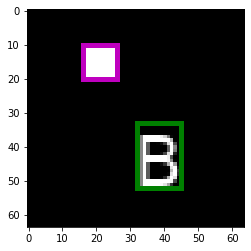

In [3]:
# Pick the first example
n = 1
print('ID: ', idx[n])
f, axs = plt.subplots(1,1)
axs.imshow(data['x_test'][idx[n]])
plot_bbox(axs, primary_lst, secondary_lst, idx[n])

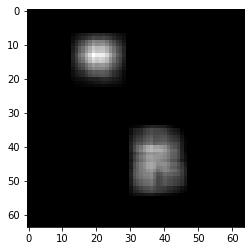

In [67]:
method_names = [x[3] for x in methods]

method_id = 7 # Integrated Gradients
pp = result[n][method_id]

pp = 1 - np.mean(pp, axis=2)
pp = cv2.blur(pp, (7,7)) # blur
pp = (pp - np.min(pp)) / (np.max(pp) - np.min(pp))

plt.imshow(pp, cmap=plt.get_cmap('gray'))

In [5]:
from smerf.eval import get_afl, get_plain_iou, get_binary_masks, get_thrs

pafl = get_afl(result[n][method_id], primary_lst[idx[n]], methods, method_id)
safl = get_afl(result[n][method_id], secondary_lst[idx[n]], methods, method_id)
piou = get_plain_iou(result[n][method_id], primary_lst[idx[n]], methods, method_id, pixel_no=247)
siou = get_plain_iou(result[n][method_id], secondary_lst[idx[n]], methods, method_id, pixel_no=247)
pafl, safl, piou, siou

(0.04324284936652686,
 0.02437405472666776,
 0.009587020648967551,
 0.025906735751295335)

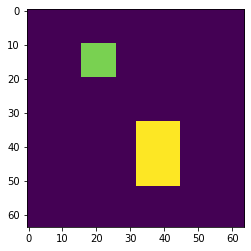

In [6]:
po = primary_lst[idx[n]][0]
so = secondary_lst[idx[n]][0]
pp = np.ones((64,64)) * 0.001
pp[po[0]:po[1],po[2]:po[3]] = 1
pp[so[0]:so[1],so[2]:so[3]] = 0.8
pp = (pp - np.min(pp)) / (np.max(pp) - np.min(pp))
plt.imshow(pp)

0.7553979299133945


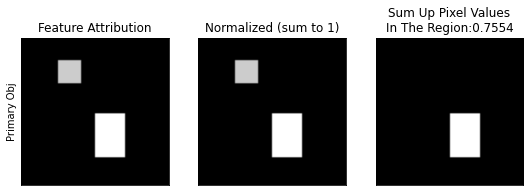

In [7]:
sal_afl = pp / pp.sum()
no_objs = len(primary_lst[idx[n]])
for i in range(no_objs):
    bbox = primary_lst[idx[n]][i]
    mask = get_binary_masks(bbox, sal_afl.shape)
    inters = sal_afl*mask
    print(inters[bbox[0]:bbox[1], bbox[2]:bbox[3]].sum())

no = 3
f,axs = plt.subplots(1, no, figsize=(3*no, 3))

# input saliency
axs[0].set_ylabel('Primary Obj')
axs[0].imshow(pp, cmap=plt.get_cmap('gray'))
axs[0].set_title('Feature Attribution')

# noramlize to sum to one
axs[1].imshow(sal_afl, cmap=plt.get_cmap('gray'))
axs[1].set_title('Normalized (sum to 1)')

# mask
axs[2].imshow(mask, cmap=plt.get_cmap('gray'))
axs[2].set_title('Sum Up Pixel Values\nIn The Region:%0.4f'%inters[bbox[0]:bbox[1], bbox[2]:bbox[3]].sum())

for i in range(no):
    axs[i].set_xticks(())
    axs[i].set_yticks(())

0.24460207008660564


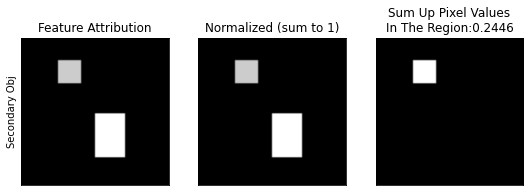

In [8]:
sal_afl = pp / pp.sum()
no_objs = len(secondary_lst[idx[n]])
for i in range(no_objs):
    bbox = secondary_lst[idx[n]][i]
    mask = get_binary_masks(bbox, sal_afl.shape)
    inters = sal_afl*mask
    print(inters[bbox[0]:bbox[1], bbox[2]:bbox[3]].sum())

no = 3
f,axs = plt.subplots(1, no, figsize=(3*no, 3))

# input saliency
axs[0].set_ylabel('Secondary Obj')
axs[0].imshow(pp, cmap=plt.get_cmap('gray'))
axs[0].set_title('Feature Attribution')

# noramlize to sum to one
axs[1].imshow(sal_afl, cmap=plt.get_cmap('gray'))
axs[1].set_title('Normalized (sum to 1)')

# mask
axs[2].imshow(mask, cmap=plt.get_cmap('gray'))
axs[2].set_title('Sum Up Pixel Values\nIn The Region:%0.4f'%inters[bbox[0]:bbox[1], bbox[2]:bbox[3]].sum())

for i in range(no):
    axs[i].set_xticks(())
    axs[i].set_yticks(())

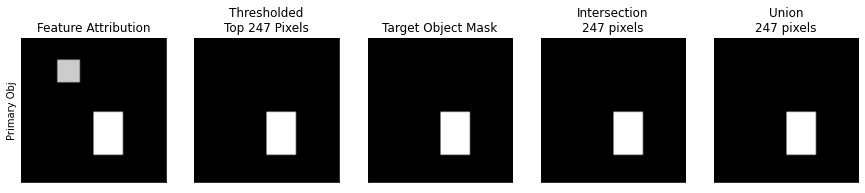

In [9]:
bb = primary_lst[idx[n]][0]
pixel_no = (bb[1] - bb[0]) * (bb[3]-bb[2])
sal_iou = np.copy(pp)
no_objs = len(primary_lst[idx[n]])
vals, bins = np.histogram(sal_iou.flatten()) # historgram of pixels
thr = get_thrs(vals, bins, pixel_no=pixel_no) # find threshold to be the value that contains around some pixels
sal_iou = np.array(sal_iou >= thr) * 1.0 # mask the image with the threshold 
for i in range(no_objs):
    bbox = primary_lst[idx[n]][i]
    mask = get_binary_masks(bbox, sal_iou.shape)
    inters = (mask + sal_iou) == 2
    union = (mask + sal_iou) != 0
    
no = 5
f,axs = plt.subplots(1, no, figsize=(3*no, 3))

# input saliency
axs[0].set_ylabel('Primary Obj')
axs[0].imshow(pp, cmap=plt.get_cmap('gray'))
axs[0].set_title('Feature Attribution')

# thresholded
axs[1].imshow(sal_iou, cmap=plt.get_cmap('gray'))
axs[1].set_title('Thresholded\nTop %d Pixels'%pixel_no)

# mask
axs[2].imshow(mask, cmap=plt.get_cmap('gray'))
axs[2].set_title('Target Object Mask')

# intersection
axs[3].imshow(inters, cmap=plt.get_cmap('gray'))
axs[3].set_title('Intersection\n%d pixels'%inters.sum())

# union
axs[4].imshow(union, cmap=plt.get_cmap('gray'))
axs[4].set_title('Union\n%d pixels'%union.sum())

for i in range(no):
    axs[i].set_xticks(())
    axs[i].set_yticks(())

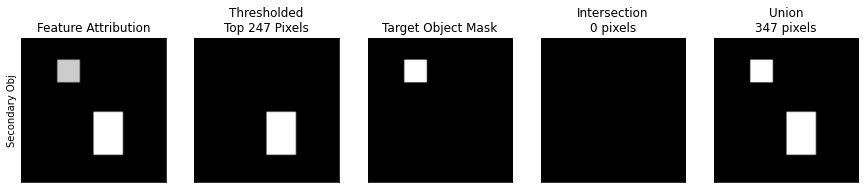

In [11]:
#bb = secondary_lst[idx[n]][0]
#pixel_no = (bb[1] - bb[0]) * (bb[3]-bb[2])
# sal_iou = np.copy(pp)
# no_objs = len(secondary_lst[idx[n]])
# vals, bins = np.histogram(sal_iou.flatten()) # historgram of pixels
# thr = get_thrs(vals, bins, pixel_no=pixel_no) # find threshold to be the value that contains around some pixels
# sal_iou = np.array(sal_iou >= thr) * 1.0 # mask the image with the threshold 
for i in range(no_objs):
    bbox = secondary_lst[idx[n]][i]
    mask = get_binary_masks(bbox, sal_iou.shape)
    inters = (mask + sal_iou) == 2
    union = (mask + sal_iou) != 0
    
no = 5
f,axs = plt.subplots(1, no, figsize=(3*no, 3))

# input saliency
axs[0].set_ylabel('Secondary Obj')
axs[0].imshow(pp, cmap=plt.get_cmap('gray'))
axs[0].set_title('Feature Attribution')

# thresholded
axs[1].imshow(sal_iou, cmap=plt.get_cmap('gray'))
axs[1].set_title('Thresholded\nTop %d Pixels'%pixel_no)

# mask
axs[2].imshow(mask, cmap=plt.get_cmap('gray'))
axs[2].set_title('Target Object Mask')

# intersection
axs[3].imshow(inters, cmap=plt.get_cmap('gray'))
axs[3].set_title('Intersection\n%d pixels'%inters.sum())

# union
axs[4].imshow(union, cmap=plt.get_cmap('gray'))
axs[4].set_title('Union\n%d pixels'%union.sum())

for i in range(no):
    axs[i].set_xticks(())
    axs[i].set_yticks(())

ID:  1325


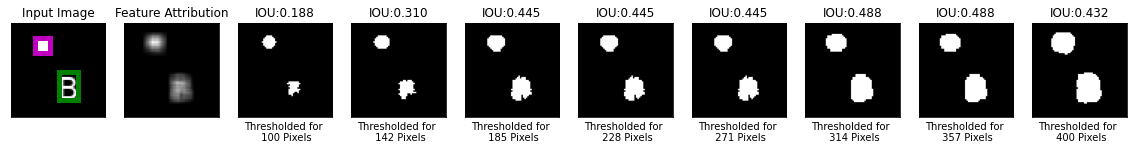

In [87]:
## Sensitivity to thresholding in IOU
method_names = [x[3] for x in methods]

# Pick the first example
n = 1
print('ID: ', idx[n])

method_id = 7 # Integrated Gradients
pp = result[n][method_id]
pp = 1 - np.mean(pp, axis=2)
pp = cv2.blur(pp, (7,7)) # blur
pp = (pp - np.min(pp)) / (np.max(pp) - np.min(pp))
po = primary_lst[idx[n]][0]
so = secondary_lst[idx[n]][0]
pixel_nos = np.linspace(100, 400, 8)
iou_vals = []
f, axs = plt.subplots(1, len(pixel_nos)+2, figsize=(len(pixel_nos)*2+4,2))

axs[0].imshow(data['x_test'][idx[n]])
plot_bbox(axs[0], primary_lst, secondary_lst, idx[n])
axs[0].set_xticks(())
axs[0].set_yticks(())
axs[0].set_title('Input Image')

axs[1].imshow(pp, cmap=plt.get_cmap('gray'))
axs[1].set_xticks(())
axs[1].set_yticks(())
axs[1].set_title('Feature Attribution')

for j,p in enumerate(pixel_nos):
    sal_iou = np.copy(pp)
    no_objs = len(primary_lst[idx[n]])
    vals, bins = np.histogram(sal_iou.flatten()) # historgram of pixels
    thr = get_thrs(vals, bins, pixel_no=int(p)) # find threshold to be the value that contains around some pixels
    sal_iou = np.array(sal_iou >= thr) * 1.0 # mask the image with the threshold 
    #plt.imshow(sal_iou)
    for i in range(no_objs):
        bbox = primary_lst[idx[n]][i]
        mask = get_binary_masks(bbox, sal_iou.shape)
        inters = (mask + sal_iou) == 2
        union = (mask + sal_iou) != 0
    iou_vals.append(inters.sum() / union.sum())
    axs[j+2].imshow(sal_iou, cmap=plt.get_cmap('gray'))
    axs[j+2].set_title('IOU:%0.3f'%iou_vals[-1])
    axs[j+2].set_xticks(())
    axs[j+2].set_yticks(())
    axs[j+2].set_xlabel('Thresholded for \n %d Pixels'%p)
plt.savefig('iou_change.pdf', dpi=200, bbox_inches='tight')

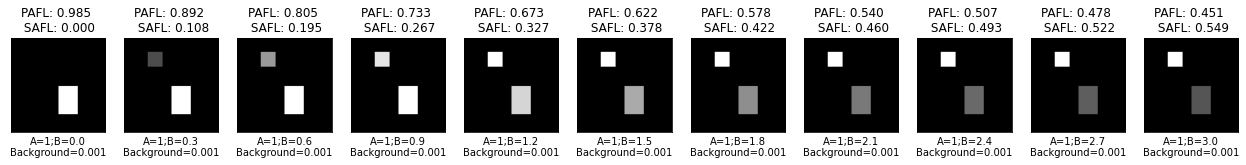

In [88]:
## Intuition about PAFL and SAFL values
so_vals = np.linspace(0, 3, 11)
f, axs = plt.subplots(1, len(so_vals), figsize=(len(so_vals)*2,2))

for j, soval in enumerate(so_vals):
    po = primary_lst[idx[n]][0]
    so = secondary_lst[idx[n]][0]
    pp = np.ones((64,64)) * 0.001
    pp[po[0]:po[1],po[2]:po[3]] = 1
    pp[so[0]:so[1],so[2]:so[3]] = soval
    pp = (pp - np.min(pp)) / (np.max(pp) - np.min(pp))
    
    sal_afl = pp / pp.sum()
    
    no_objs = len(primary_lst[idx[n]])
    for i in range(no_objs):
        bbox = primary_lst[idx[n]][i]
        mask = get_binary_masks(bbox, sal_afl.shape)
        inters = sal_afl*mask
        pafl = inters[bbox[0]:bbox[1], bbox[2]:bbox[3]].sum()
    
    no_objs = len(secondary_lst[idx[n]])
    for i in range(no_objs):
        bbox = secondary_lst[idx[n]][i]
        mask = get_binary_masks(bbox, sal_afl.shape)
        inters = sal_afl*mask
        safl = inters[bbox[0]:bbox[1], bbox[2]:bbox[3]].sum()
        
    axs[j].set_title('PAFL: %0.3f \n SAFL: %0.3f'%(pafl, safl))
    axs[j].set_xlabel('A=1;B=%0.1f\nBackground=%0.3f'%(soval, 0.001))
    axs[j].imshow(pp, cmap=plt.get_cmap('gray'))
    axs[j].set_xticks(())
    axs[j].set_yticks(())
plt.savefig('afl_value_change1.pdf', dpi=200)
    

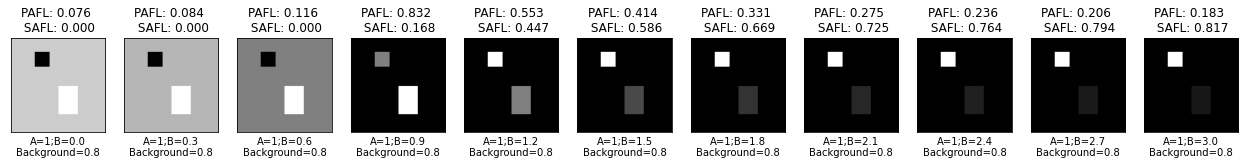

In [45]:
## PAFL, SAFL, and Background 
so_vals = np.linspace(0, 3, 11)
f, axs = plt.subplots(1, len(so_vals), figsize=(len(so_vals)*2,2))

for j, soval in enumerate(so_vals):
    po = primary_lst[idx[n]][0]
    so = secondary_lst[idx[n]][0]
    pp = np.ones((64,64)) * 0.8
    pp[po[0]:po[1],po[2]:po[3]] = 1
    pp[so[0]:so[1],so[2]:so[3]] = soval
    pp = (pp - np.min(pp)) / (np.max(pp) - np.min(pp))
    
    sal_afl = pp / pp.sum()
    
    no_objs = len(primary_lst[idx[n]])
    for i in range(no_objs):
        bbox = primary_lst[idx[n]][i]
        mask = get_binary_masks(bbox, sal_afl.shape)
        inters = sal_afl*mask
        pafl = inters[bbox[0]:bbox[1], bbox[2]:bbox[3]].sum()
    
    no_objs = len(secondary_lst[idx[n]])
    for i in range(no_objs):
        bbox = secondary_lst[idx[n]][i]
        mask = get_binary_masks(bbox, sal_afl.shape)
        inters = sal_afl*mask
        safl = inters[bbox[0]:bbox[1], bbox[2]:bbox[3]].sum()
        
    axs[j].set_title('PAFL: %0.3f \n SAFL: %0.3f'%(pafl, safl))
    axs[j].imshow(pp, cmap=plt.get_cmap('gray'))
    axs[j].set_xlabel('A=1;B=%0.1f\nBackground=%0.1f'%(soval, 0.8))

    axs[j].set_xticks(())
    axs[j].set_yticks(())
    